# Mushroom classifier

In [52]:
import os
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.models.mobilenet import mobilenet_v3_large
from torchvision import transforms
import torch.utils.data as data

## Read folder of folders of images

In [2]:
def read_images_folder(folder_path):
    """
    Read images from a specified folder path.

    Args:
        folder_path (str): The path of the folder containing the images.

    Returns:
        tuple: A tuple containing a list of images and a list of folder names.
    """
    images = []
    labels = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            if file.endswith(('.jpg', '.png')):
                image = read_image(file_path)
                if image is not None:
                    images.append(image)
                    folder_name = os.path.basename(root)
                    labels.append(folder_name)
    
    # convert labels to first character of labels
    labels = [int(label[0]) for label in labels]
    return images, labels

def read_image(file_path):
    """
    Read an image from a specified file path.

    Args:
        file_path (str): The path of the image file to be read.

    Returns:
        PIL.Image.Image or None: The opened image if successful, or None if an error occurs.

    """
    try:
        with Image.open(file_path) as image:
            return image.copy()
    except (IOError, SyntaxError) as e:
        print(f"Error opening image: {file_path} - {e}")
        return None

def convert_images_to_tensors(images):
    """
    Convert a list of images to tensors.

    Args:
        images (list): A list of PIL.Image.Image objects.

    Returns:
        list: A list of converted torch.Tensor objects.

    """
    tensor_images = []
    for image in images:
        tensor = ToTensor()(image)
        tensor_images.append(tensor)
    return tensor_images

In [4]:
images, labels = read_images_folder(folder_path = 'data')
tensor_images = convert_images_to_tensors(images)

/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2966: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


Error opening image: data/5_2_amanita_muscaria/amanita-muscaria-4.jpg - cannot identify image file 'data/5_2_amanita_muscaria/amanita-muscaria-4.jpg'
Error opening image: data/5_2_amanita_muscaria/amanita-muscaria.jpg - cannot identify image file 'data/5_2_amanita_muscaria/amanita-muscaria.jpg'
Error opening image: data/4_2_cantharellus_cibarius/66837183-chanterelle-or-girolle-mushrooms-cantharellus-cibarius-clippng-path.jpg - cannot identify image file 'data/4_2_cantharellus_cibarius/66837183-chanterelle-or-girolle-mushrooms-cantharellus-cibarius-clippng-path.jpg'
Error opening image: data/3_2_boletus_badius/75534892-boletus-badius-commonly-known-as-the-bay-bolete-growing-in-the-forest.jpg - cannot identify image file 'data/3_2_boletus_badius/75534892-boletus-badius-commonly-known-as-the-bay-bolete-growing-in-the-forest.jpg'
Error opening image: data/3_2_boletus_badius/148456648-boletus-badius-mushroom-also-known-as-xerocomus-badius-on-moss.jpg - cannot identify image file 'data/3_2_b

## Inspect images

In [5]:
print("Number of images: " + str(len(images)))

Number of images: 7880


In [6]:
def inspect_random_images(images, folders):
    """
    Display a grid of randomly selected images with their corresponding label.

    Args:
        images (list): A list of torch.Tensor objects representing the images.
        folders (list): A list of labels corresponding to the images.

    Returns:
        None

    """
    random_indices = random.sample(range(len(images)), 9)  # Select 9 random indices
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))  # Create a 3x3 grid of subplots

    for i, ax in enumerate(axes.flatten()):
        index = random_indices[i]
        image_tensor = images[index]
        folder_name = folders[index]

        # Convert image tensor to a NumPy array
        image_np = image_tensor.permute(1, 2, 0).cpu().numpy()

        # Display the image
        ax.imshow(image_np)
        ax.set_title(folder_name)
        ax.axis('off')

    plt.tight_layout()  # Adjust subplot spacing
    plt.show()

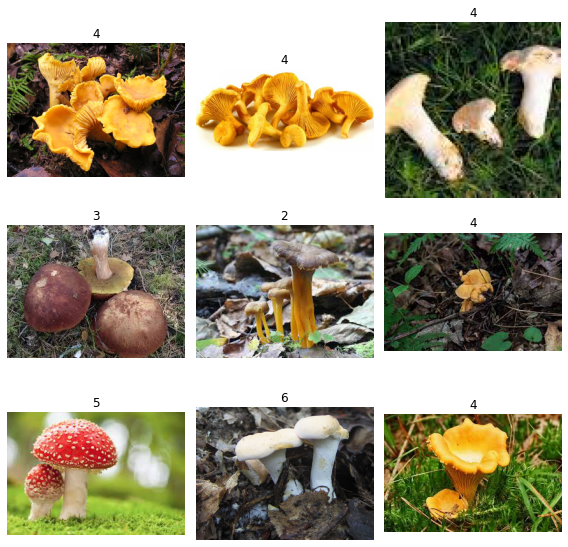

In [9]:
inspect_random_images(tensor_images, labels)

## Preprocess images

### Filter only images with three colour channels

In [72]:
def filter_tensors_with_three_channels(tensor_images, labels):
    """
    Filters a list of tensors to only include tensors with three channels.
    Removes labels with the same index as the images that have less than three channels.

    Args:
        tensor_images (list): A list of tensors.
        labels (list): A list of labels corresponding to the tensor images.

    Returns:
        tuple: A tuple containing two lists - the filtered tensors and filtered labels.
    """
    filtered_tensors = []
    filtered_labels = []
    for tensor, label in zip(tensor_images, labels):
        if tensor.shape[0] == 3:
            filtered_tensors.append(tensor)
            filtered_labels.append(label)
    return filtered_tensors, filtered_labels

In [73]:
tensor_images_3_channels, labels_3_channels = filter_tensors_with_three_channels(tensor_images, labels)

In [74]:
print("Number of images with three channels: " + str(len(tensor_images_3_channels)))

Number of images with three channels: 7737


### Filter out images where mean pixel value within an acceptable margin

In [76]:
def filter_tensors_with_threshold(tensor_images, labels, red_good, green_good, blue_good, acceptable_deviation):
    """
    Filters a list of tensors based on threshold criteria for average pixel values.
    Removes labels with the same index as the images that do not meet the threshold criteria.

    Args:
        tensor_images (list): A list of tensors.
        labels (list): A list of labels corresponding to the tensor images.
        red_good (float): Threshold for the average red pixel value.
        green_good (float): Threshold for the average green pixel value.
        blue_good (float): Threshold for the average blue pixel value.
        acceptable_deviation (float): Acceptable deviation from the thresholds.

    Returns:
        tuple: A tuple containing two lists - the filtered tensors and filtered labels.
    """
    filtered_tensors = []
    filtered_labels = []
    for tensor, label in zip(tensor_images, labels):
        red_avg = tensor[0].mean()
        green_avg = tensor[1].mean()
        blue_avg = tensor[2].mean()

        if (
            red_good - acceptable_deviation <= red_avg <= red_good + acceptable_deviation and
            green_good - acceptable_deviation <= green_avg <= green_good + acceptable_deviation and
            blue_good - acceptable_deviation <= blue_avg <= blue_good + acceptable_deviation
        ):
            filtered_tensors.append(tensor)
            filtered_labels.append(label)

    return filtered_tensors, filtered_labels


In [78]:
red_good = 82/255
green_good = 75/255
blue_good = 65/255
acceptable_deviation = 40/255

tensor_images_good_colours, labels_good_colours = filter_tensors_with_threshold(
    tensor_images_3_channels,
    labels_3_channels,
    red_good,
    green_good,
    blue_good,
    acceptable_deviation
)

In [79]:
print("Number of images: " + str(len(tensor_images_3_channels_good_colours)))

Number of images: 3219


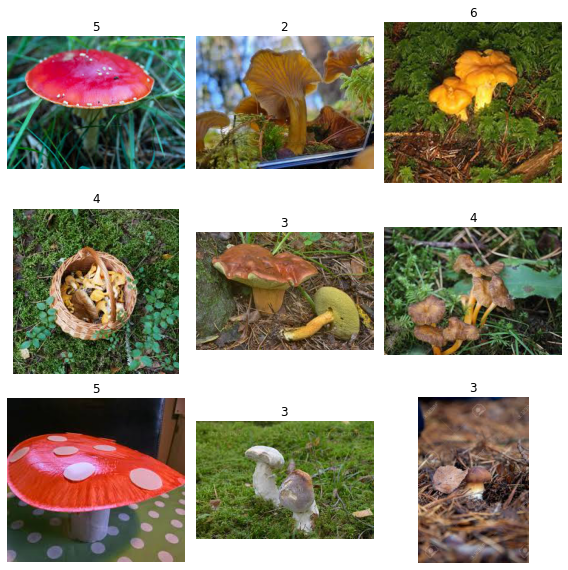

In [82]:
inspect_random_images(tensor_images_good_colours, labels_good_colours)

### Resize images

In [83]:
def resize_images(image_tensor_list):
    """
    Resize a list of image tensors to a specified size.

    Args:
        image_tensor_list (list): A list of torch.Tensor objects representing the images.

    Returns:
        list: A list of resized image tensors.

    """
    resized_images = []

    for image_tensor in image_tensor_list:
        image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        image_tensor = image_tensor.squeeze(0)

        resized_images.append(image_tensor)

    return resized_images

In [85]:
# Resize the images
resized_images = resize_images(tensor_images_good_colours)

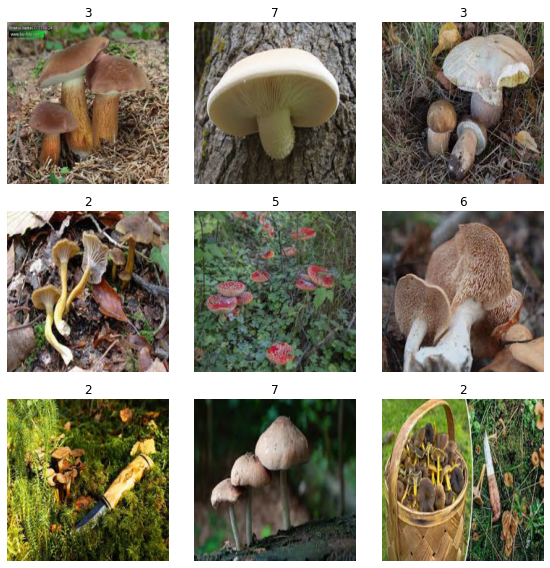

In [87]:
inspect_random_images(resized_images, labels_good_colours)

### Normalize images like Imagen

In [89]:
def normalize_mobilenetv3(images):
    """
    Normalize a list of images using the MobileNetV3 normalization values.

    Args:
        images (list): A list of input images.

    Returns:
        torch.Tensor: A tensor containing the normalized images.

    """
    preprocess = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    preprocessed_images = []
    for image in images:
        preprocessed_image = preprocess(image)
        preprocessed_images.append(preprocessed_image)

    input_tensor = torch.stack(preprocessed_images)
    return input_tensor

In [90]:
# Normalize according to Imagen
normalized_images = normalize_mobilenetv3(resized_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


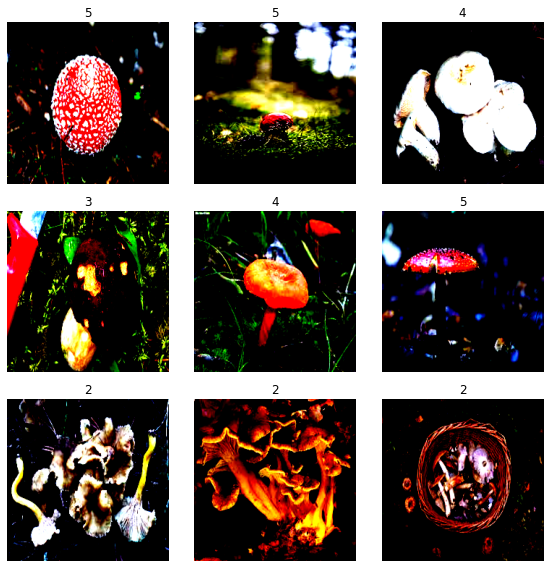

In [91]:
# Example usage
inspect_random_images(normalized_images, labels_good_colours)

## Preprocess labels

In [64]:
def one_hot_encode(labels):
    """
    Perform one-hot encoding on a list of categorical labels.

    Args:
        labels (list): A list of categorical labels.

    Returns:
        numpy.ndarray: An array of one-hot encoded labels.

    """
    # Convert the list of strings into numerical labels
    label_encoder = LabelEncoder()
    numerical_labels = label_encoder.fit_transform(labels)

    # Perform one-hot encoding
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_labels = onehot_encoder.fit_transform(numerical_labels.reshape(-1, 1))

    return onehot_labels

def tensor_converter(labels):
    """
    Convert a numpy array of one-hot encoded labels to a PyTorch tensor.

    Args:
        labels (numpy.ndarray): The one-hot encoded labels as a numpy array.

    Returns:
        torch.Tensor: The one-hot encoded labels as a PyTorch tensor.
    """
    return torch.from_numpy(labels)


In [92]:
one_hot_encoded_labels = one_hot_encode(labels_good_colours)
labels_tensor = tensor_converter(one_hot_encoded_labels)

## Train model

This project uses the MobileNetV3 architecture. MobileNetV3 is a convolutional neural network architecture designed for efficient and accurate image classification on mobile and embedded devices. It introduces several novel features, including the use of a combination of depthwise separable convolutions and linear bottlenecks to reduce computation while preserving model capacity. It also incorporates a hard sigmoid activation function to improve efficiency and employs multiple inverted residual blocks with squeeze-and-excitation modules for better feature representation. MobileNetV3 achieves state-of-the-art performance on image classification tasks while maintaining a small model size and low latency, making it ideal for resource-constrained devices.

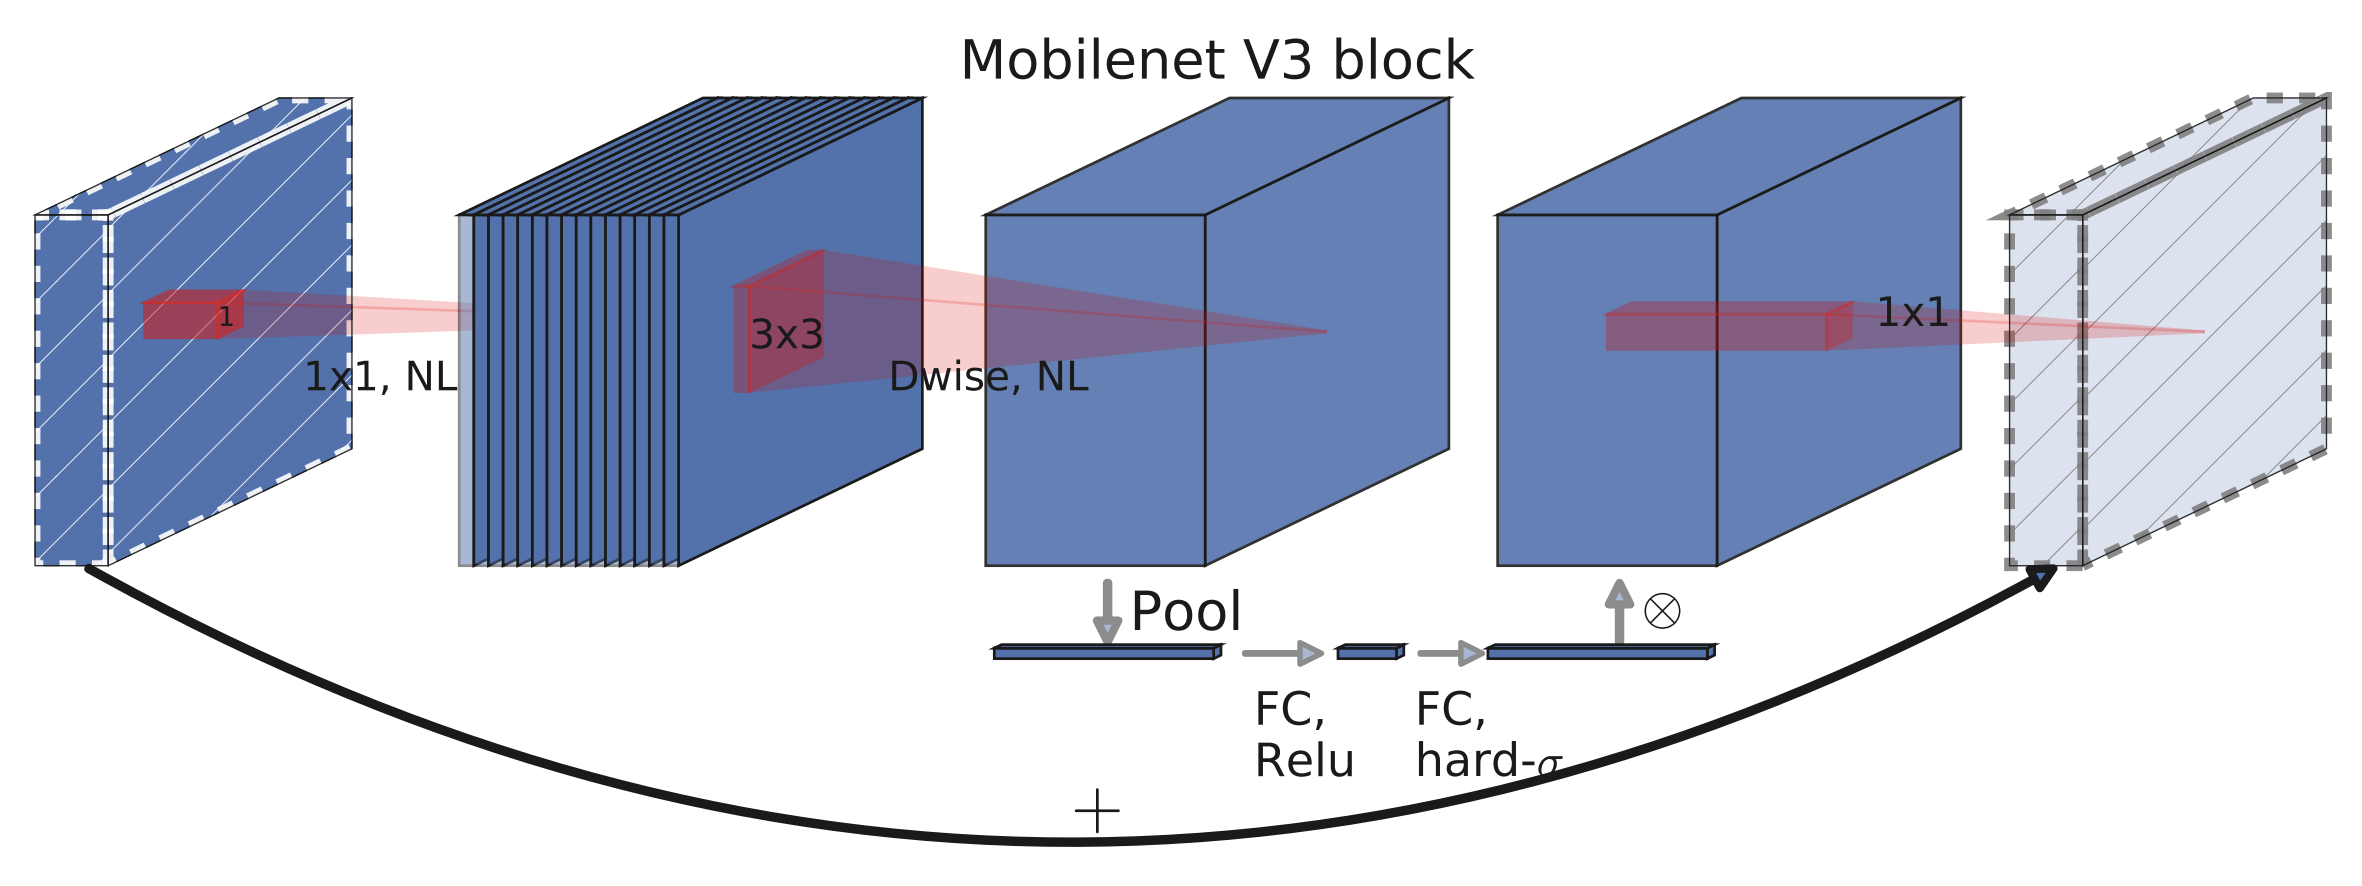

In [93]:
def create_dataloader(images, labels, batch_size=32, shuffle=True):
    """
    Create a DataLoader for batching and shuffling the data.

    Args:
        images (torch.Tensor): A tensor containing the images.
        labels (torch.Tensor): A tensor containing the labels.
        batch_size (int, optional): The batch size. Defaults to 32.
        shuffle (bool, optional): Whether to shuffle the data. Defaults to True.

    Returns:
        torch.utils.data.DataLoader: The created DataLoader.

    """
    
    # Convert to tensor dataset
    dataset = data.TensorDataset(images, labels)
    dataloader = data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def initialize_model(num_classes):
    """
    Initialize a MobileNetV3-Large model with ImageNet weights and replace the last
    classification layer.

    Args:
        num_classes (int): The number of output classes for the model.

    Returns:
        torch.nn.Module: The initialized and modified MobileNetV3-Large model.

    """
    # Initialize MobileNetV3-Large model with ImageNet weights
    model = mobilenet_v3_large(pretrained=True)
    
    # Replace the last classification layer
    num_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(num_features, num_classes)
    
    return model

def train(model, dataloader, num_epochs, device):
    """
    Train a model using the provided dataloader for the specified number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the training data.
        num_epochs (int): The number of epochs to train the model.
        device (torch.device): The device to be used for training.

    Returns:
        torch.nn.Module: The trained model.

    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    model = model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss}")

    return model

def evaluate(model, dataloader, device):
    """
    Evaluate a trained model using the provided dataloader.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the evaluation data.
        device (torch.device): The device to be used for evaluation.

    Returns:
        float: Accuracy of the model on the evaluation data.
        float: Precision of the model on the evaluation data.
        float: Recall of the model on the evaluation data.
        float: F1-score of the model on the evaluation data.
        torch.Tensor: Confusion matrix of the model predictions.

    """
    model = model.to(device)
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(targets.tolist())
            y_pred.extend(predicted.tolist())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    confusion_mat = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, confusion_mat

In [94]:
dataloader = create_dataloader(images = normalized_images,
                               labels = labels_tensor,
                               batch_size=32,
                               shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Initiating training on " + str(device))

# Initialize the model
model = initialize_model(num_classes = len(np.unique(labels)))

Initiating training on cpu


In [ ]:
# Train and evaluate the model
trained_model = train(model, dataloader, num_epochs, device)
accuracy, precision, recall, f1, confusion_mat = evaluate(trained_model, dataloader, device)

print(f"Accuracy: {accuracy}%")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print("Confusion Matrix:")
print(confusion_mat)